Epoch 0: Train Loss = 0.6919, Validation Loss = 0.6625
Epoch 100: Train Loss = 0.3906, Validation Loss = 0.3210
Epoch 200: Train Loss = 0.3901, Validation Loss = 0.3175
Epoch 300: Train Loss = 0.3901, Validation Loss = 0.3173
Epoch 400: Train Loss = 0.3900, Validation Loss = 0.3172
Epoch 500: Train Loss = 0.3900, Validation Loss = 0.3172
Epoch 600: Train Loss = 0.3899, Validation Loss = 0.3171
Epoch 700: Train Loss = 0.3899, Validation Loss = 0.3170
Epoch 800: Train Loss = 0.3898, Validation Loss = 0.3170
Epoch 900: Train Loss = 0.3897, Validation Loss = 0.3169


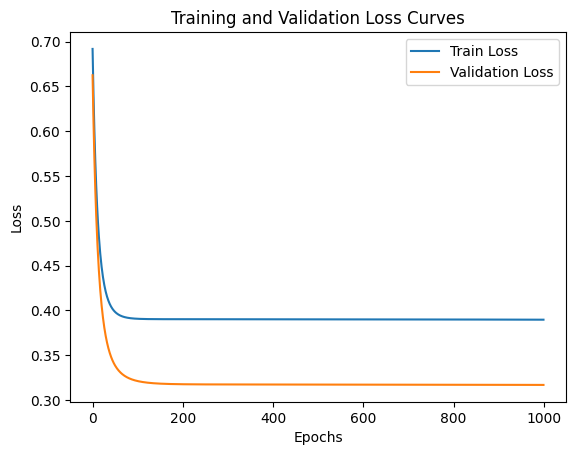


Test Set Evaluation:
Accuracy: 0.8720
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('weather_forecast_data.csv')

# Step 2: Separate features (X) and labels (y) manually
X_list = []
y_list = []

for i in range(len(data)):
    row = list(data.loc[i])
    X_list.append(row[:-1])
    y_list.append(row[-1])

# Convert labels ('rain' -> 1, 'no rain' -> 0)
y_converted = []
for value in y_list:
    if value == 'rain':
        y_converted.append(1)
    else:
        y_converted.append(0)

# Convert to numpy arrays
X = np.array(X_list, dtype=float)
y = np.array(y_converted, dtype=float).reshape(-1, 1)

# Normalize features
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean) / X_std

# Split the data manually
m = len(X)
train_end = int(0.7 * m)
val_end = int(0.85 * m)

X_train = X[:train_end]
y_train = y[:train_end]

X_val = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test = X[val_end:]
y_test = y[val_end:]

#Activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)

#Loss function
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Initialize weights
def initialize_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}
    for l in range(1, len(layer_dims)):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

# Forward propagation
def forward_propagation(X, parameters):
    caches = {}
    A = X.T  # (n_features, m_samples)
    caches['A0'] = A
    L = len(parameters) // 2

    for l in range(1, L + 1):
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        Z = np.dot(W, A) + b
        A = sigmoid(Z)
        caches['Z' + str(l)] = Z
        caches['A' + str(l)] = A

    return A, caches

# Backward propagation
def backward_propagation(parameters, caches, X, Y):
    grads = {}
    m = X.shape[0]
    L = len(parameters) // 2
    Y = Y.T

    dA = -(np.divide(Y, caches['A' + str(L)]) - np.divide(1 - Y, 1 - caches['A' + str(L)]))

    for l in reversed(range(1, L + 1)):
        dZ = dA * sigmoid_derivative(caches['A' + str(l)])
        A_prev = caches['A' + str(l-1)]
        W = parameters['W' + str(l)]

        grads['dW' + str(l)] = (1/m) * np.dot(dZ, A_prev.T)
        grads['db' + str(l)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        
        if l > 1:
            dA = np.dot(W.T, dZ)

    return grads

# Update parameters
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]

    return parameters

# Training the model
def model(X_train, y_train, X_val, y_val, layer_dims, learning_rate=0.01, num_epochs=1000):
    parameters = initialize_parameters(layer_dims)
    train_losses = []
    val_losses = []

    for i in range(num_epochs):
        A_train, caches_train = forward_propagation(X_train, parameters)
        train_loss = cross_entropy_loss(y_train, A_train.T)

        grads = backward_propagation(parameters, caches_train, X_train, y_train)
        parameters = update_parameters(parameters, grads, learning_rate)

        A_val, _ = forward_propagation(X_val, parameters)
        val_loss = cross_entropy_loss(y_val, A_val.T)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if i % 100 == 0:
            print(f"Epoch {i}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")

    return parameters, train_losses, val_losses

# Predict function
def predict(X, parameters):
    A, _ = forward_propagation(X, parameters)
    return (A > 0.5).astype(int).T

# Evaluation Metrics
def compute_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    return accuracy, precision, recall, f1

# taking 2 hidden layers (say 8 and 4 neurons)
layer_dims = [X_train.shape[1], 8, 4, 1]

parameters, train_losses, val_losses = model(X_train, y_train, X_val, y_val, layer_dims, learning_rate=0.1, num_epochs=1000)

# Plot loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()


y_pred_test = predict(X_test, parameters)
acc, prec, rec, f1 = compute_metrics(y_test, y_pred_test)

print("\nTest Set Evaluation:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")